# Adaptive numerical Quadrature
We will demonstrate how to train a NN to intelligently choose step sizes in numerical quadrature. We will focus on the following example: Integrate sine functions from the class
$$ X = \left\{f : f(x) = \sin(\omega x + \varphi) ~\Big|~ \omega, \phi \in \mathbb{R} \right\} $$ with probability measure $\omega, \varphi \sim \text{Unif}[0,2\pi]$ as best as possible using Simpson's rule. Let us store some information about this task in the following variables:

In [1]:
import numpy as np
from adaptive.integrator import Simpson

integrator = Simpson()

step_sizes = [0.05, 0.1, 0.15, 0.2, 0.3, 0.4, 0.5, 0.75]  # the NN will choose from these step sizes
tol = 0.0005  # target integration error tolerance
nodes_per_step = 3  # Simpson's rule uses 3 nodes per integration step
x0 = 0  # start point
x1 = 20  # end point

dim_action = len(step_sizes)  # the dimension of the action space of the NN
memory = 0  # how many integration steps the predictor can look back

 It is a good idea to scale the inputs of the NN to order $\approx 10^{-1}$. For this purpose we will use a scikit-learn StandardScaler.

In [2]:
from sklearn.preprocessing import StandardScaler
import joblib

scaler = joblib.load('adaptive/model_quad/model_sinus/Simpson/scaler.bin')

Now we can finally initialize the NN. It is encapsuled by the Predictor object, which handles the interaction with the NN. The NN itself is created using tensorflow.

In [3]:
from adaptive.predictor import PredictorQ
from adaptive.build_models import build_value_model

predictor = PredictorQ(step_sizes=step_sizes,
                       model=build_value_model(dim_state=nodes_per_step, dim_action=dim_action, memory=memory),
                       scaler=scaler)

During the training process, we have to reward or penalize the NN for its step choices. We choose a reward function of the following form: If the integration error is below the tolerance, reward the NN with a value scaling with the chosen time step, i.e. bigger time step yields bigger reward. If the integration error is higher than the tolerance, penalize the NN with a value scaling with the error, i.e. bigger error yields more negative rewards. Here we choose the `RewardExp` reward function, which has a linear scaling for positive the rewards and exponentially decaying negative rewards.

In [4]:
from adaptive.reward_functions import RewardExp

step_size_range = (step_sizes[0], step_sizes[-1])  # range of expected step sizes
reward_range = (0.1, 2)  # range of positive rewards

reward_fun = RewardExp(error_tol=tol, step_size_range=step_size_range, reward_range=reward_range)

# some example rewards
# format (error, step size, reward)
print([(0.5 * tol, h, reward_fun(0.5 * tol, h)) for h in step_sizes])
print([(to, step_sizes[0], reward_fun(to, step_sizes[0])) for to in np.linspace(tol, 5 * tol, 5)])

[(0.00025, 0.05, 0.1), (0.00025, 0.1, 0.23571428571428574), (0.00025, 0.15, 0.37142857142857144), (0.00025, 0.2, 0.5071428571428572), (0.00025, 0.3, 0.7785714285714286), (0.00025, 0.4, 1.05), (0.00025, 0.5, 1.3214285714285714), (0.00025, 0.75, 1.9999999999999998)]
[(0.0005, 0.05, 0.0), (0.001, 0.05, -1.0), (0.0015, 0.05, -1.5), (0.002, 0.05, -1.75), (0.0025, 0.05, -1.875)]


In order to train the NN, we will need to repeatedly sample and integrate functions from the given class. The `IntegrationEnv` class handles the integration process. The most important method is `IntegrationEnv.iterate`, which takes a step size as an argument, integrates the function with the provided step size for one step, and provides the next state as an output. Moreover, the `IntegrationEnv` class keeps track of the integration error and calculates the rewards for the step size choices.

In [5]:
from adaptive.environments import IntegrationEnv
from functions import Sinus

env = IntegrationEnv(fun=Sinus(), max_iterations=128, initial_step_size=0.1, step_size_range=(step_sizes[0], step_sizes[-1]),
                     error_tol=tol, nodes_per_integ=nodes_per_step, memory=memory)

During the integration process, we will store a few past states and desired NN outputs in an `Experience` object. If a certain number of experiences is stored or the integration is finished, we use the stored data (batch) to train the NN.

In [6]:
from adaptive.experience import Experience

experience = Experience(batch_size=32)

While training, it is important for the NN to explore the action space in order to find the optimal step sizes for a given input. We will use the following function to randomly choose actions given the NN's output:

In [7]:
def choose_action(actions, eps):
    """
    With probability (1-eps) choose the action with highest expected reward.
    Otherwise choose different action depending on expected reward.

    Parameters
    ----------
    actions : np.ndarray
    eps : float

    Returns
    -------
    int
    """
    sort_act = np.squeeze(np.argsort(-actions))
    dim_a = len(np.squeeze(actions))
    if dim_a == 2:
        probs = [1 - eps, eps]
    else:
        a = - 1 / (dim_a - 1) * np.log(0.01 / (1 - eps))
        probs = [(1 - eps) * np.exp(-a * idx) for idx in range(dim_a)]
        probs[1:dim_a - 1] = probs[1:dim_a - 1] / np.linalg.norm(probs[1:dim_a - 1], 1) * (eps - 0.01)

    return sort_act[np.random.choice(dim_a, p=probs)]

Finally, we are able to train the NN. The following training loop showcases the training process for a few episodes. However, we will load a fully trained NN afterwards, so that you do not have to do the training yourself.

In [8]:
gamma = 0  # discount factor for future rewards

for episode in range(2):
    state = env.reset()
    reward_total = 0
    loss_this_episode = 0
    steps = 0
    done = False
    eps = 0.5

    print('episode: {}'.format(episode))

    while not done:
        # get action from actor
        actions = predictor.get_actions(state)
        action = choose_action(actions, eps)
        step_size = predictor.action_to_stepsize(action)

        # execute action
        next_state, reward, done, _ = env.iterate(step_size, integrator)
        steps += 1
        reward_total += reward

        # find target values for NN output
        action_next_state = predictor.get_actions(next_state)
        target = reward + gamma * np.max(action_next_state)
        target_actions = actions.squeeze()
        target_actions[action] = target
        experience.append(state=state, target=target_actions)
            
        if experience.is_full() or done:
            states, targets = experience.get_samples()
            loss_predictor = predictor.train_on_batch(states, targets)
            loss_this_episode += loss_predictor
            experience.reset()

        state = next_state

    print('reward: {}'.format(reward_total))
    print('loss_predictor: {}'.format(loss_this_episode))

    # uncomment if you want to train the NN yourself and save the weights
    # predictor.model.save_weights('predictor')

episode: 0

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: No module named 'tensorflow_core.estimator'
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: No module named 'tensorflow_core.estimator'
reward: 100.77501224081398
loss_predictor: 0.37464916706085205
episode: 1
r

In [9]:
# load the already trained NN
predictor.model = build_value_model(dim_state=nodes_per_step, dim_action=dim_action, memory=memory,
                                    filename='adaptive/model_quad/model_sinus/Simpson/predictor')

Before we begin to evaluate the performance of the step predictor, let us plot an integration of a sample function. (Repeat execution of next cell to sample different functions.)


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

Predictor error total: 0.008847321103253406
Predictor error per step: 0.0001361126323577447
Predictor evals: 131


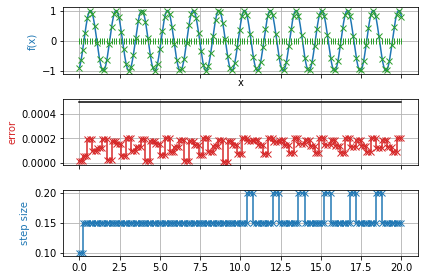

In [10]:
from adaptive.comparison import integrate_env

env.reset()
_, evals, _, errors = integrate_env(predictor, integrator, env, x0=x0, x1=x1)

print('Predictor error total: {}'.format(np.sum(errors)))
print('Predictor error per step: {}'.format(np.mean(errors)))
print('Predictor evals: {}'.format(evals))

env.plot(x_min=x0, x_max=x1)

Now we will compare the performance of our NN step size predictor to the equidistant Simpson's rule and to a subdivision algorithm. (If the execution of the next block takes a lot of time on your machine, you can reduce `num_samples`.)

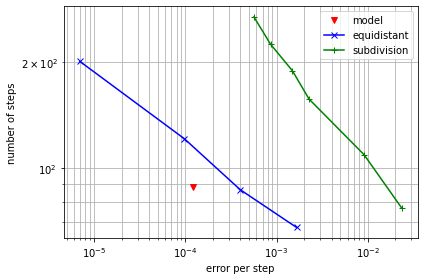

In [11]:
num_samples = 500 # number of functions to sample from the class

# performance NN
errors = []
evals = []
for i in range(num_samples):
    env.reset()
    _, num_evals, _, err = integrate_env(predictor, integrator, env, x0, x1)
    errors.append(np.mean(err))
    evals.append(num_evals)

perf_model = np.array([np.mean(errors), np.mean(evals)])

# performance equidistant
from adaptive.adapt_simps import Simps  # equidistant composite Simpson's rule
step_s = np.linspace(0.1, 0.3, 4)  # step sizes for equidistant Simpson's rule
perf_eq = []

for h in step_s:
    errors = []
    for _ in range(num_samples):
        env.reset()
        simp = Simps(env.fun, x0, x1)
        _, error_simps_step = simp(step_size=h, stepwise_error=True)
        errors.append(np.mean(error_simps_step))
    perf_eq.append([np.mean(errors), (x1 - x0) / h + 1])
perf_eq = np.array(perf_eq)

# performance subdivision method
from adaptive.adapt_simps import AdaptSimpsConstEvals  # subdivision method with fixed number of evaluations
nevals = [75, 108, 155, 186, 223, 268]  # different numbers of function evaluations
perf_sub = []

for neval in nevals:
    errors = []
    evals = []
    for _ in range(num_samples):
        env.reset()
        asr = AdaptSimpsConstEvals(env.fun, x0, x1)
        asr(neval)
        stepwise_errors = asr.stepwise_errors
        errors.append(np.mean(stepwise_errors))
        evals.append(asr.evals)
    perf_sub.append([np.mean(errors), np.mean(evals)])
perf_sub = np.array(perf_sub)

# plot results
from matplotlib import pyplot as plt
plt.loglog(perf_model[0], perf_model[1], 'rv', label='model')
plt.loglog(perf_eq[:, 0], perf_eq[:, 1], 'bx-', label='equidistant')
plt.loglog(perf_sub[:, 0], perf_sub[:, 1], 'g+-', label='subdivision')
plt.legend()
plt.xlabel('error per step')
plt.ylabel('number of steps')
plt.grid(which='both')
plt.tight_layout()
plt.show()


Let us finally optimize the weights of the used quadrature rule for this class of functions instead of using the standard Simpson's rule. First we will acquire training data by sampling and integrating functions from the class using the NN adaptive time stepper. Then we use a scikit-learn `LinearRegression` to optimize the weights for each of the step sizes in `step_sizes`. If the data acquisition takes too long on your machine, you can load in already optimized weights later.

In [12]:
# acquire training data
num_episodes = 300  # number of functions to sample and integrate

num_step_sizes = len(step_sizes)
states = [[] for _ in range(num_step_sizes)]  # states[i] is a list of states with the i_th step_size
integrals = [[] for _ in range(num_step_sizes)]  # integrals[i] is a list with the associated correct integrals

for episode in range(num_episodes):
    state = env.reset()
    done = False

    while not done:
        actions = predictor.get_actions(state)
        action = np.argmax(actions)
        next_state, reward, done, info = env.iterate(predictor.action_to_stepsize(action), integrator)
        fa = info["f_a"]
        f_evals = next_state[1:env.nodes_per_integ]
        f_evals = np.concatenate(([fa], f_evals + fa))
        states[action].append(f_evals)
        integrals[action].append(info["correct_integral"])
        state = next_state

In [13]:
# optimize weights using linear regression
from sklearn.linear_model import LinearRegression

models = []
for step_size_idx in range(len(step_sizes)):
    print("{} samples for step_size {}".format(len(states[step_size_idx]), step_size_idx))
    step_size = step_sizes[step_size_idx]

    if len(states[step_size_idx]) < 10:
        # there are not enough samples for a reliable calculation -> choose simpson
        model = LinearRegression()
        weights = 2 * step_size * np.array([1, 4, 1]) / 6
        model.coef_ = weights
        model.intercept_ = np.zeros((1,))
    
    else:
        X = np.stack(states[step_size_idx])
        y = np.array(integrals[step_size_idx])
        model = LinearRegression().fit(X, y)

        # disregard the 10% of worst data and fit again
        pred = model.predict(X)
        error = np.abs(y - pred)
        ind = error.argsort()[-(len(error) // 10):][::-1]
        X = np.delete(X, ind, axis=0)
        y = np.delete(y, ind)
        model = LinearRegression().fit(X, y)

        if np.linalg.norm(model.coef_) < 1e-4 * step_size:
            # weights are = 0 -> use Simpson
            weights = 2 * step_size * np.array([1, 4, 1]) / 6
            model.coef_ = weights
            model.intercept_ = np.zeros((1,))
    models.append(model)

    print("weights: {}".format(model.coef_))
    print("intercept: {}".format(model.intercept_))
    print('')

0 samples for step_size 0
weights: [0.01666667 0.06666667 0.01666667]
intercept: [0.]

0 samples for step_size 1
weights: [0.03333333 0.13333333 0.03333333]
intercept: [0.]

16189 samples for step_size 2
weights: [0.05106932 0.19801728 0.0510681 ]
intercept: 6.256297808938591e-08

5056 samples for step_size 3
weights: [0.06779276 0.26453755 0.06779918]
intercept: 9.849724855182096e-10

4575 samples for step_size 4
weights: [0.10198989 0.39628222 0.10199451]
intercept: 1.5187750056384897e-06

3412 samples for step_size 5
weights: [0.13554158 0.5291594  0.13553637]
intercept: 2.250621872403047e-06

3665 samples for step_size 6
weights: [0.16872551 0.66272521 0.16871604]
intercept: 2.2093207058121456e-06

5503 samples for step_size 7
weights: [0.25191518 0.99619723 0.25192956]
intercept: 2.083294429605642e-06



In [14]:
# optional: load optimal weights
# models = load('adaptive/model_quad/model_sinus/Simpson/linreg_models.bin')

In [15]:
# build integrator with optimized weights
from adaptive.integrator import IntegratorLinReg
integrator = IntegratorLinReg(step_sizes, models)

Finally, we will evaluate the performance of the model with optimized weights.

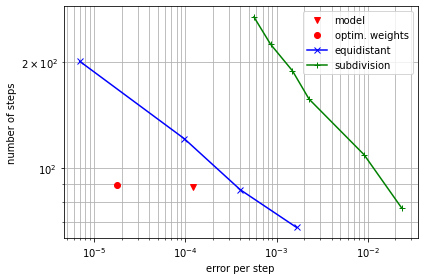

In [16]:
num_samples = 500 # number of functions to sample from the class

# performance NN with optimized weights
errors = []
evals = []
for i in range(num_samples):
    env.reset()
    _, num_evals, _, err = integrate_env(predictor, integrator, env, x0, x1)
    errors.append(np.mean(err))
    evals.append(num_evals)

perf_model_weights = np.array([np.mean(errors), np.mean(evals)])

# plot results
from matplotlib import pyplot as plt
plt.loglog(perf_model[0], perf_model[1], 'rv', label='model')
plt.loglog(perf_model_weights[0], perf_model_weights[1], 'ro', label='optim. weights')
plt.loglog(perf_eq[:, 0], perf_eq[:, 1], 'bx-', label='equidistant')
plt.legend()
plt.xlabel('error per step')
plt.ylabel('number of steps')
plt.grid(which='both')
plt.tight_layout()
plt.show()